## Select articles: look for hateful comments

In [3]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
from mongoengine import connect
from hatespeech_models import Tweet, Article

client = connect("hatespeech-selection")
db = client["hatespeech-selection"]

Article.objects.count()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


68896

Acá tomamos a partir del 1ro de marzo...

In [4]:
import datetime

start_date = datetime.datetime(2020, 3, 1)

base_query = {
    "dummy__ne": True,
    "comments__19__exists": True,
    "created_at__gte": start_date,
}

Article.objects(**base_query).count()

10314

In [21]:
import random
from mongoengine import DoesNotExist
from hatespeech_models import Reply
from collections import defaultdict

comment_seeds = [
    # Mujer
    "bija",
    "\"prostituta\"",
    #"\"trola\"",
    
    "feministas",
    "feminazis",
    "aborteras",
    #"\"boluda\" -\"gente\"",
    "\"botox\"",
    #"\"puta\"",
    #"\"gato\"",
    "\"urraca\"",
    "tucán",
    # LGBTI
    "marica",
    "\"viejo puto\"",    
    "\"trabuco\"",
    "travesti",
    "\"trava\"",
    "\"degenerado\"",
    #"\"puto\"",
    "trolo -\"no seas\" -\"no sean\"",
    "\"sodomita\"",
    
    # Xenofobia, Racismo, Religión
    "chinos",
    "\"sucios\"",
    "bolita",
    # Lo pongo así porque "Paraguay" lo usan contra macri
    "\"paraguayo\"",
    "\"peruano\"",
    "\"peruca\"",
    "judío",
    
    "\"jude\"",
    "sionista",
    "\"matarlos\"",
    "\"una bomba\"",
    
    # Pobreza
    
    #"\"vagos\"",
    "\"vayan a laburar\"",
    "\"vayan a trabajar\"",
    #"\"negros de mierda\"",
    #"\"negro de mierda\"",
    #"\"negra de mierda\"",
    "\"planero\"",
    "\"villeros\"",
    #"\"negro\" \"hdp\"",
    "negro -\"en negro\" -\"Rio\" -\"peste\" -\"humor negro\"",
    #parásitos
    # Política
    #"\"terrorista\"",
    
    # Violentos
    "\"bala\"",

    "\"uno menos\"",
    # Aspecto
    "\"gorda\"",
]

new_article_ids = set()

votes = defaultdict(list)
reason = {}
seed_articles = {}

for word in comment_seeds:
    nuevos = 0
    limit = None
    if type(word) is tuple:
        word, limit = word
    """
    for _ in range(3):
        print("="*80)
        
    print(f"\n\n{word}\n\n")
    """
    replies = Reply.objects.no_dereference().search_text(word)
    article_ids = [rep.article.id for rep in replies]
    articles = Article.objects(id__in=article_ids, **base_query)
    total_count = articles.count()
    
    for rep in replies:
        votes[rep.article.id].append(word)
    
    for article in articles:
        try:
            if article.id not in seed_articles:
                nuevos += 1
                seed_articles[article.id] = article
                reason[article.id] = f"Comment -- {word} ({word})"
                if limit and nuevos >= limit:
                    break
            else:
                pass
                #print(f"\nSkipping {article} -- Reason: {reason[article.id]}")
        except DoesNotExist as e:
            pass
            #print(f"\nSkipping {Article.objects.get(id=rep.article.id)} -- {e}")

    print(f"{word[:30]:<30} ---> {nuevos:<4} nuevos/ {total_count:<5} total comentarios --> {len(seed_articles):<5} artículos al momento", end="")
    
    if limit:
        print(f" (limitados a {limit})")
    else:
        print("")


bija                           ---> 47   nuevos/ 47    total comentarios --> 47    artículos al momento
"prostituta"                   ---> 146  nuevos/ 148   total comentarios --> 193   artículos al momento
feministas                     ---> 270  nuevos/ 301   total comentarios --> 463   artículos al momento
feminazis                      ---> 46   nuevos/ 86    total comentarios --> 509   artículos al momento
aborteras                      ---> 110  nuevos/ 159   total comentarios --> 619   artículos al momento
"botox"                        ---> 56   nuevos/ 69    total comentarios --> 675   artículos al momento
"urraca"                       ---> 52   nuevos/ 65    total comentarios --> 727   artículos al momento
tucán                          ---> 66   nuevos/ 96    total comentarios --> 793   artículos al momento
marica                         ---> 55   nuevos/ 69    total comentarios --> 848   artículos al momento
"viejo puto"                   ---> 53   nuevos/ 67    total com

Los jevis:

- "negro": 1532 comentarios
- "planero": 886
- "chinos": 1926



In [22]:
len(seed_articles)

4905

Cantidad artículos con más de 2 votos : 3692
Cantidad artículos con más de 3 votos : 2140
Cantidad artículos con más de 4 votos : 1513
Cantidad artículos con más de 5 votos : 1139
Cantidad artículos con más de 6 votos : 878
Cantidad artículos con más de 7 votos : 706
Cantidad artículos con más de 8 votos : 597
Cantidad artículos con más de 9 votos : 496


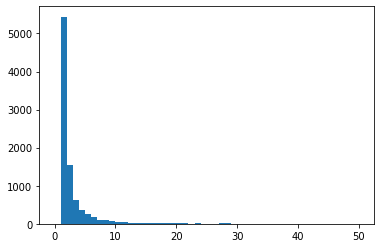

In [23]:
import matplotlib.pyplot as plt

for k in range(2, 10):
    count = 0
    for _, v in votes.items():
        if len(v) >= k:
            count += 1
    print(f"Cantidad artículos con más de {k} votos : {count}")

plt.hist([len(v) for v in votes.values()], bins=50, range=[0, 50]);


Me quedo sólo con los artículos que tengan al menos 2 votos

In [24]:
selected_articles = {k: v for k, v in votes.items() if len(v) >= 2}
selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)

selected_articles.count()

2831

Les pongo la descripción de su elección

In [25]:
Article.objects.update(set__description="")

68896

In [26]:
from tqdm.auto import tqdm
from collections import Counter

for article in tqdm(selected_articles):
    this_art_votes = votes[article.id]
    
    article.description = str(dict(Counter(this_art_votes)))
    article.save()

In [27]:
from groups.models import Group

def accept_article(art):
    politicians = ["Ginés", "Mauricio Macri", "Alberto Fernández", "Magario"]
    
    if any(p.lower() in art.title.lower() for p in politicians):
        return len(votes[art.id]) >= 5
    return True
    
    
for k in [2, 3, 4, 5]:
    try:
        group = Group.objects.get(name=f"Seed comments - {k} votes")
    except DoesNotExist:
        group = Group(name=f"Seed comments - {k} votes")
    selected_articles = {article_id: v for article_id, v in votes.items() if len(v) >= k}
    selected_articles = Article.objects(id__in=selected_articles.keys(), **base_query)
    selected_articles = [a for a in selected_articles if accept_article(a)]
    print(f"{k} votes -- {len(selected_articles)} articles")
    group.articles = selected_articles
    
    group.save()
    


2 votes -- 2573 articles
3 votes -- 1695 articles
4 votes -- 1289 articles
5 votes -- 1034 articles


In [28]:
group = Group.objects.no_dereference().get(name="Seed comments - 4 votes")

In [29]:
article_ids = [a.id for a in group.articles]
Article.objects.update(set__selected=False)
updated = Article.objects(id__in=article_ids).update(set__selected=True)
print(f"Marcados como seleccionados {updated} artículos")

Marcados como seleccionados 1289 artículos


## Comparaciones de "negro"

In [61]:
Reply.objects.search_text("negro").count()

5374

In [68]:
Reply.objects.search_text("negro -\"en negro\"").count()

4773

In [69]:
Reply.objects.search_text("negro -\"en negro\" -\"Rio\"").count()

4350

In [70]:
Reply.objects.search_text("negro -\"en negro\" -\"Rio\" -\"peste\"").count()

4270

Mucho mejor!

In [80]:
from collections import defaultdict

def show_articles_with(query):
    articles = defaultdict(list)

    for r in Reply.objects.search_text(query):
        articles[r.article].append(r)
        
    print(f"Hay {len(articles)}")
    for art, comments in articles.items():
        print("="*80)
        print(art.title, "\n\n")
        for comm in comments:
            print(comm.text)

In [ ]:
show_articles_with("negro -\"en negro\" -\"Rio\" -\"peste\"")

In [72]:
len(articles)

2168

Acá es mejor sacando Río!

In [ ]:
%%capture
from pprint import pprint as pp

for j, art in enumerate(selected_articles):
    print(f"{j:<5} -- {art.title}")
    print("\n")
    pp(art.first_paragraphs)
    print(f"Razón: {reason[art.id]}")
    
    comments = random.sample(art.comments, 10)
    
    for repl in comments:
        print(repl.text)
    print("\n\n")